In [2]:
#Multisalad!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

In [4]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.platform import tf_logging as logging
from tensorflow.keras.callbacks import Callback, EarlyStopping

2022-09-30 02:16:51.812219: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-30 02:16:51.812299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [469]:
N = 2000
s = 8

np.random.seed(s)
data = np.concatenate([np.random.normal(-1,0.2,N),np.random.normal(1,0.2,N)])
anomaly = np.concatenate([np.random.normal(-2,0.2,int(N*0.05)), np.random.normal(2,0.2,int(N*0.05))])
sim1 = np.concatenate([np.random.normal(0,1,N),np.random.normal(1,0.2,N)])
sim2 = np.concatenate([np.random.normal(-1,0.2,N),np.random.normal(0,1,N)])

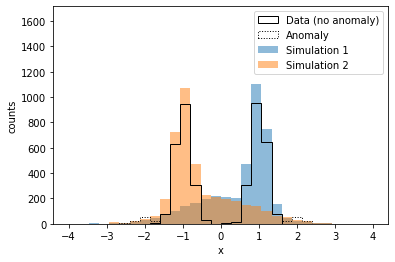

In [470]:
n,b,_=plt.hist(data,bins=30,histtype="step",color="black", range=(-4, 4), label="Data (no anomaly)")
_,_,_=plt.hist(anomaly,bins=b,histtype="step",color="black",ls=":",label="Anomaly")
_,_,_=plt.hist(sim1,bins=b,alpha=0.5,label="Simulation 1")
_,_,_=plt.hist(sim2,bins=b,alpha=0.5,label = "Simulation 2")
plt.legend(frameon=True)
plt.ylim([0,max(n)*1.8])
plt.xlabel("x")
plt.ylabel("counts")

plt.savefig("./figs/salad_data_distr.pdf")

In [471]:
def split_data(x):
    n = x.shape[0]
    indices = np.random.permutation(n)

    indices_1 = indices[: int(n/2)]
    indices_2 = indices[int(n/2):]


    return x[indices_1], x[indices_2]

In [472]:
# shuffle and split each dataset
# np.random.seed(42)

X_data_sb, X_data_sr = split_data(data)
X_sim1_sb, X_sim1_sr = split_data(sim1)
X_sim2_sb, X_sim2_sr = split_data(sim2)
anomaly_sb, anomaly_sr = split_data(anomaly)


n_data_sb, n_data_sr = X_data_sb.shape[0], X_data_sr.shape[0]
n_sim1_sb, n_sim1_sr = X_sim1_sb.shape[0], X_sim1_sr.shape[0]
n_sim2_sb, n_sim2_sr = X_sim2_sb.shape[0], X_sim2_sr.shape[0]
n_anomaly_sb, n_anomaly_sr = anomaly_sb.shape[0], anomaly_sr.shape[0]

In [473]:
#First, the models to reweight the simulation to the data

#sim 1 -> data
model_rw_sim1 = Sequential()
model_rw_sim1.add(Dense(32, input_dim=1, activation='relu'))
model_rw_sim1.add(Dense(32, activation='relu'))
model_rw_sim1.add(Dense(32, activation='relu'))
model_rw_sim1.add(Dense(1, activation='sigmoid'))
model_rw_sim1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 2 -> data
model_rw_sim2 = Sequential()
model_rw_sim2.add(Dense(32, input_dim=1, activation='relu'))
model_rw_sim2.add(Dense(32, activation='relu'))
model_rw_sim2.add(Dense(32, activation='relu'))
model_rw_sim2.add(Dense(1, activation='sigmoid'))
model_rw_sim2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 1 + sim 2 -> data
model_rw_sim12 = Sequential()
model_rw_sim12.add(Dense(32, input_dim=1, activation='relu'))
model_rw_sim12.add(Dense(32, activation='relu'))
model_rw_sim12.add(Dense(32, activation='relu'))
model_rw_sim12.add(Dense(1, activation='sigmoid'))
model_rw_sim12.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#now, train classifiers to distinguish data (with anomaly) to simulation. 
#I'm assuming the interpolation to the signal region is exactly correct.

#sim 1 versus data
model_ad_sim1 = Sequential()
model_ad_sim1.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim1.add(Dense(32, activation='relu'))
model_ad_sim1.add(Dense(32, activation='relu'))
model_ad_sim1.add(Dense(1, activation='sigmoid'))
model_ad_sim1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 1 (after reweigthing) versus data
model_ad_sim1_rw = Sequential()
model_ad_sim1_rw.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim1_rw.add(Dense(32, activation='relu'))
model_ad_sim1_rw.add(Dense(32, activation='relu'))
model_ad_sim1_rw.add(Dense(1, activation='sigmoid'))
model_ad_sim1_rw.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 2 versus data
model_ad_sim2 = Sequential()
model_ad_sim2.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim2.add(Dense(32, activation='relu'))
model_ad_sim2.add(Dense(32, activation='relu'))
model_ad_sim2.add(Dense(1, activation='sigmoid'))
model_ad_sim2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 2 (after reweigthing) versus data
model_ad_sim2_rw = Sequential()
model_ad_sim2_rw.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim2_rw.add(Dense(32, activation='relu'))
model_ad_sim2_rw.add(Dense(32, activation='relu'))
model_ad_sim2_rw.add(Dense(1, activation='sigmoid'))
model_ad_sim2_rw.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 1+2 versus data
model_ad_sim12 = Sequential()
model_ad_sim12.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim12.add(Dense(32, activation='relu'))
model_ad_sim12.add(Dense(32, activation='relu'))
model_ad_sim12.add(Dense(1, activation='sigmoid'))
model_ad_sim12.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#sim 1+2 (after reweigthing) versus data
model_ad_sim12_rw = Sequential()
model_ad_sim12_rw.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim12_rw.add(Dense(32, activation='relu'))
model_ad_sim12_rw.add(Dense(32, activation='relu'))
model_ad_sim12_rw.add(Dense(1, activation='sigmoid'))
model_ad_sim12_rw.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_ad_sim_multi_rw = Sequential()
model_ad_sim_multi_rw.add(Dense(32, input_dim=1, activation='relu'))
model_ad_sim_multi_rw.add(Dense(32, activation='relu'))
model_ad_sim_multi_rw.add(Dense(32, activation='relu'))
model_ad_sim_multi_rw.add(Dense(1, activation='sigmoid'))
model_ad_sim_multi_rw.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [474]:
# Construct data for first step

#sim 1 -> data
x_vals_rw_sim1 = np.concatenate([X_data_sb, X_sim1_sb])
y_vals_rw_sim1 = np.concatenate([np.ones(len(X_data_sb)),np.zeros(len(X_sim1_sb))])
X_train_rw_sim1, X_val_rw_sim1, Y_train_rw_sim1, Y_val_rw_sim1 = train_test_split(x_vals_rw_sim1, y_vals_rw_sim1, random_state=42)

#sim 2 -> data
x_vals_rw_sim2 = np.concatenate([X_data_sb, X_sim2_sb])
y_vals_rw_sim2 = np.concatenate([np.ones(len(X_data_sb)),np.zeros(len(X_sim2_sb))])
X_train_rw_sim2, X_val_rw_sim2, Y_train_rw_sim2, Y_val_rw_sim2 = train_test_split(x_vals_rw_sim2, y_vals_rw_sim2, random_state=42)

#sim 1+2 -> data
x_vals_rw_sim12 = np.concatenate([X_data_sb, X_sim1_sb, X_sim2_sb])
y_vals_rw_sim12 = np.concatenate([np.ones(len(X_data_sb)),np.zeros(len(X_sim1_sb)),np.zeros(len(X_sim2_sb))])
X_train_rw_sim12, X_val_rw_sim12, Y_train_rw_sim12, Y_val_rw_sim12 = train_test_split(x_vals_rw_sim12, y_vals_rw_sim12, random_state=42)

In [475]:
myhistory_rw_sim1 = model_rw_sim1.fit(X_train_rw_sim1, Y_train_rw_sim1, epochs=50 ,batch_size=200,verbose=0)
print("Done with 1")
myhistory_rw_sim2 = model_rw_sim2.fit(X_train_rw_sim2, Y_train_rw_sim2, epochs=50 ,batch_size=200,verbose=0)
print("Done with 2")
myhistory_rw_sim12 = model_rw_sim12.fit(X_train_rw_sim12, Y_train_rw_sim12, epochs=50 ,batch_size=200,verbose=0)
print("Done with 1+2")

Done with 1
Done with 2
Done with 1+2


In [476]:
preds_val_rw_sim1 = model_rw_sim1.predict(X_val_rw_sim1,batch_size=1000)
preds_val_rw_sim2 = model_rw_sim2.predict(X_val_rw_sim2,batch_size=1000)
preds_val_rw_sim12 = model_rw_sim12.predict(X_val_rw_sim12,batch_size=1000)

2/2 [==============================] - 0s 2ms/step


Text(0, 0.5, 'counts')

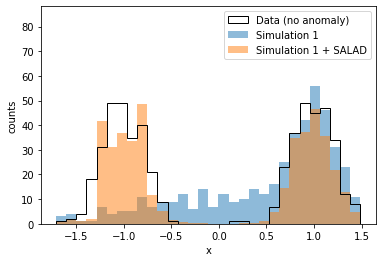

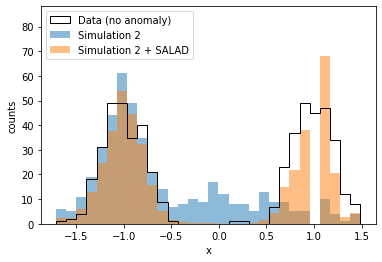

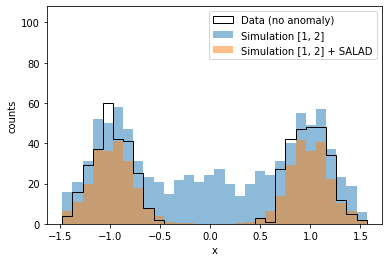

In [477]:
plt.figure()
n,b,_=plt.hist(X_val_rw_sim1[Y_val_rw_sim1==1],bins=30,histtype="step",color="black",label="Data (no anomaly)")
_,_,_=plt.hist(X_val_rw_sim1[Y_val_rw_sim1==0],bins=b,alpha=0.5,label="Simulation 1")
_,_,_=plt.hist(X_val_rw_sim1[Y_val_rw_sim1==0],weights =preds_val_rw_sim1[Y_val_rw_sim1==0]/(1.-preds_val_rw_sim1[Y_val_rw_sim1==0]), bins=b,alpha=0.5,label="Simulation 1 + SALAD")
plt.legend(frameon=True)
plt.ylim([0,max(n)*1.8])
plt.xlabel("x")
plt.ylabel("counts")
# plt.savefig("./figs/salad_1.pdf")

plt.figure()
n,b,_=plt.hist(X_val_rw_sim2[Y_val_rw_sim2==1],bins=30,histtype="step",color="black",label="Data (no anomaly)")
_,_,_=plt.hist(X_val_rw_sim2[Y_val_rw_sim2==0],bins=b,alpha=0.5,label="Simulation 2")
_,_,_=plt.hist(X_val_rw_sim2[Y_val_rw_sim2==0],weights =preds_val_rw_sim2[Y_val_rw_sim2==0]/(1.-preds_val_rw_sim2[Y_val_rw_sim2==0]), bins=b,alpha=0.5,label="Simulation 2 + SALAD")
plt.legend(frameon=True)
plt.ylim([0,max(n)*1.8])
plt.xlabel("x")
plt.ylabel("counts")
# plt.savefig("./figs/salad_2.pdf")

plt.figure()
n,b,_=plt.hist(X_val_rw_sim12[Y_val_rw_sim12==1],bins=30,histtype="step",color="black",label="Data (no anomaly)")
_,_,_=plt.hist(X_val_rw_sim12[Y_val_rw_sim12==0],bins=b,alpha=0.5,label="Simulation [1, 2]")
_,_,_=plt.hist(X_val_rw_sim12[Y_val_rw_sim12==0],weights =preds_val_rw_sim12[Y_val_rw_sim12==0]/(1.-preds_val_rw_sim12[Y_val_rw_sim12==0]), bins=b,alpha=0.5,label="Simulation [1, 2] + SALAD")
plt.legend(frameon=True)
plt.ylim([0,max(n)*1.8])
plt.xlabel("x")
plt.ylabel("counts")
# plt.savefig("./figs/salad_12.pdf")

In [478]:
#Now, for the classification models.

#sim 1 versus data
x_vals_ad_sim1 = np.concatenate([X_data_sr, anomaly_sr, X_sim1_sr])
y_vals_ad_sim1 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),np.zeros(len(X_sim1_sr))])
preds = model_rw_sim1.predict(X_sim1_sr,batch_size=1000).flatten()
w_vals_ad_sim1 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),preds/(1.-preds)])
X_train_ad_sim1, X_val_ad_sim1, Y_train_ad_sim1, Y_val_ad_sim1, W_train_ad_sim1, W_val_ad_sim1 = train_test_split(x_vals_ad_sim1, y_vals_ad_sim1, w_vals_ad_sim1, random_state=42)

#sim 2 versus data
x_vals_ad_sim2 = np.concatenate([X_data_sr,anomaly_sr,X_sim2_sr])
y_vals_ad_sim2 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),np.zeros(len(X_sim2_sr))])
preds = model_rw_sim2.predict(X_sim2_sr,batch_size=1000).flatten()
w_vals_ad_sim2 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),preds/(1.-preds)])
X_train_ad_sim2, X_val_ad_sim2, Y_train_ad_sim2, Y_val_ad_sim2, W_train_ad_sim2, W_val_ad_sim2 = train_test_split(x_vals_ad_sim2, y_vals_ad_sim2, w_vals_ad_sim2, random_state=42)

#sim 1+2 versus data
x_vals_ad_sim12 = np.concatenate([X_data_sr,anomaly_sr,X_sim1_sr,X_sim2_sr])
y_vals_ad_sim12 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),np.zeros(len(X_sim1_sr)),np.zeros(len(X_sim2_sr))])

preds12 = model_rw_sim12.predict(np.concatenate([X_sim1_sr, X_sim2_sr]),batch_size=1000).flatten()
w_vals_ad_sim12 = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),preds12/(1.-preds12)])

preds1 = model_rw_sim1.predict(X_sim1_sr, batch_size=1000).flatten()
preds2 = model_rw_sim2.predict(X_sim2_sr, batch_size=1000).flatten()
preds_multi = np.concatenate([preds1, preds2])
w_vals_ad_sim_multi = np.concatenate([np.ones(len(X_data_sr)),np.ones(len(anomaly_sr)),preds_multi/(1.-preds_multi)])

X_train_ad_sim12, X_val_ad_sim12, Y_train_ad_sim12, Y_val_ad_sim12, W_train_ad_sim12, W_val_ad_sim12, W_train_ad_sim_multi, W_val_ad_sim_multi = train_test_split(x_vals_ad_sim12, y_vals_ad_sim12, w_vals_ad_sim12, w_vals_ad_sim_multi, random_state=42)

2/2 [==============================] - 0s 4ms/step


Text(0, 0.5, 'counts')

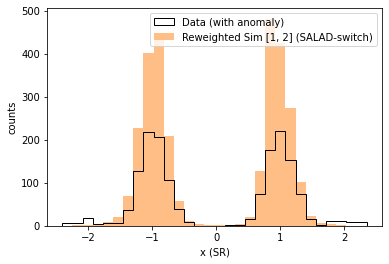

In [479]:
# weight_multi can blow things up due to high variance 
plt.figure()

n,b,_=plt.hist(X_train_ad_sim12[Y_train_ad_sim12==1], histtype="step", color="black", bins=30,label="Data (with anomaly)")

_,_,_=plt.hist(X_train_ad_sim12[Y_train_ad_sim12==0], weights=W_train_ad_sim_multi[(W_train_ad_sim_multi != 1) & (W_train_ad_sim_multi != 0)], color="tab:orange", alpha=0.5,bins=b,label="Reweighted Sim [1, 2] (SALAD-switch)")
# plt.ylim([0,max(n)*1.8])
#plt.hist(np.concatenate([X_sim1_sr, X_sim2_sr]), weights=w, color="green",alpha=0.5,bins=b,label="simulation")
#plt.hist(preds_anomalyboth,density=True,histtype="step",color="black",bins=b,label="Signal")
plt.legend()
plt.xlabel("x (SR)")
plt.ylabel("counts")
# plt.savefig("./figs/salad_12_reweighting.pdf")


Text(0, 0.5, 'counts')

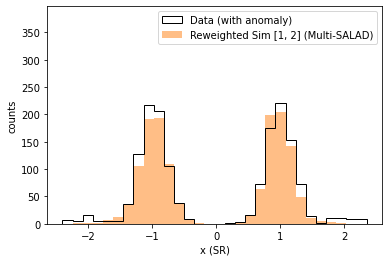

In [480]:
# weight_multi can blow things up due to high variance 
plt.figure()
n,b,_=plt.hist(X_train_ad_sim12[Y_train_ad_sim12==1],histtype="step", color="black", bins=30,label="Data (with anomaly)")
#n1,_,_=plt.hist(X_train_both[Y_train_both==0],color="orange",alpha=0.5,bins=b,label="sim")
_,_,_=plt.hist(X_train_ad_sim12[Y_train_ad_sim12==0], weights=W_train_ad_sim12[(W_train_ad_sim12 != 1) & (W_train_ad_sim12 != 0)], color="tab:orange", alpha=0.5,bins=b,label="Reweighted Sim [1, 2] (Multi-SALAD)")
plt.ylim([0,max(n)*1.8])

#plt.hist(np.concatenate([X_sim1_sr, X_sim2_sr]), weights=w, color="green",alpha=0.5,bins=b,label="simulation")
#plt.hist(preds_anomalyboth,density=True,histtype="step",color="black",bins=b,label="Signal")
plt.legend()
plt.legend()
plt.xlabel("x (SR)")
plt.ylabel("counts")
# plt.savefig("./figs/salad_multi_reweighting.pdf")


Text(0, 0.5, 'counts')

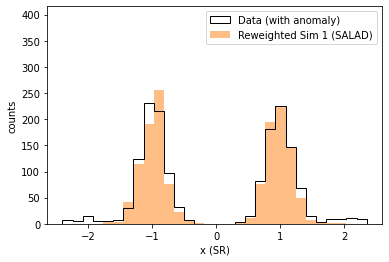

In [481]:
# weight_multi can blow things up due to high variance 
plt.figure()
n,b,_=plt.hist(X_train_ad_sim1[Y_train_ad_sim1==1],histtype="step", color="black", bins=30,label="Data (with anomaly)")
#n1,_,_=plt.hist(X_train_both[Y_train_both==0],color="orange",alpha=0.5,bins=b,label="sim")
_,_,_=plt.hist(X_train_ad_sim1[Y_train_ad_sim1==0], weights=W_train_ad_sim1[(W_train_ad_sim1 != 1) & (W_train_ad_sim1 != 0)], color="tab:orange", alpha=0.5,bins=b,label="Reweighted Sim 1 (SALAD)")

plt.ylim([0,max(n)*1.8])

#plt.hist(np.concatenate([X_sim1_sr, X_sim2_sr]), weights=w, color="green",alpha=0.5,bins=b,label="simulation")
#plt.hist(preds_anomalyboth,density=True,histtype="step",color="black",bins=b,label="Signal")
plt.legend()
plt.xlabel("x (SR)")
plt.ylabel("counts")
# plt.savefig("./figs/salad_1_reweighting.pdf")


Text(0, 0.5, 'counts')

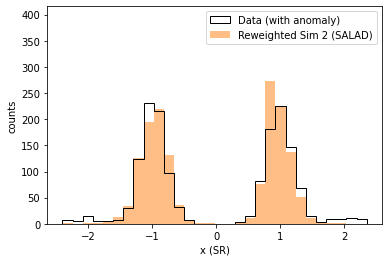

In [482]:
# weight_multi can blow things up due to high variance 
plt.figure()
n,b,_=plt.hist(X_train_ad_sim2[Y_train_ad_sim2==1],histtype="step", color="black", bins=30,label="Data (with anomaly)")
#n1,_,_=plt.hist(X_train_both[Y_train_both==0],color="orange",alpha=0.5,bins=b,label="sim")
_,_,_=plt.hist(X_train_ad_sim2[Y_train_ad_sim2==0], weights=W_train_ad_sim2[(W_train_ad_sim2 != 1) & (W_train_ad_sim2 != 0)], color="tab:orange", alpha=0.5,bins=b,label="Reweighted Sim 2 (SALAD)")

plt.ylim([0,max(n)*1.8])

#plt.hist(np.concatenate([X_sim1_sr, X_sim2_sr]), weights=w, color="green",alpha=0.5,bins=b,label="simulation")
#plt.hist(preds_anomalyboth,density=True,histtype="step",color="black",bins=b,label="Signal")
plt.legend()
plt.xlabel("x (SR)")
plt.ylabel("counts")
# plt.savefig("./figs/salad_2_reweighting.pdf")


In [483]:
myhistory_ad_sim1 = model_ad_sim1.fit(X_train_ad_sim1, Y_train_ad_sim1, epochs=50 ,batch_size=200,verbose=0)
print("Done with 1")
myhistory_ad_sim1_rw = model_ad_sim1_rw.fit(X_train_ad_sim1, Y_train_ad_sim1, sample_weight = W_train_ad_sim1, epochs=50 ,batch_size=200,verbose=0)
print("Done with 1 rw")
myhistory_ad_sim2 = model_ad_sim2.fit(X_train_ad_sim2, Y_train_ad_sim2, epochs=50 ,batch_size=200,verbose=0)
print("Done with 2")
myhistory_ad_sim2_rw = model_ad_sim2_rw.fit(X_train_ad_sim2, Y_train_ad_sim2, sample_weight = W_train_ad_sim2, epochs=50 ,batch_size=200,verbose=0)
print("Done with 2 rw")
myhistory_ad_sim12 = model_ad_sim12.fit(X_train_ad_sim12, Y_train_ad_sim12, epochs=50 ,batch_size=200,verbose=0)
print("Done with 12")
myhistory_ad_sim12_rw = model_ad_sim12_rw.fit(X_train_ad_sim12, Y_train_ad_sim12, sample_weight = W_train_ad_sim12, epochs=50 ,batch_size=200,verbose=0)
print("Done with 12 rw")
myhistory_ad_sim_multi_rw = model_ad_sim_multi_rw.fit(X_train_ad_sim12, Y_train_ad_sim12, sample_weight = W_train_ad_sim_multi, epochs=50 ,batch_size=200,verbose=0)
print("Done with multi rw")

Done with 1
Done with 1 rw
Done with 2
Done with 2 rw
Done with 12
Done with 12 rw
Done with multi rw


In [484]:
#independent test set

class0 = np.concatenate([np.random.normal(-1,0.2,100000),np.random.normal(1,0.2,100000)])
class1 = np.concatenate([np.random.normal(-2,0.2,100000), np.random.normal(2,0.2,100000)])

In [485]:
from sklearn import metrics

In [486]:
scores0 = model_ad_sim1.predict(class0,batch_size=1000)
scores1 = model_ad_sim1.predict(class1,batch_size=1000)
fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(np.concatenate([np.ones(len(scores1)),np.zeros(len(scores0))]), np.concatenate([scores1,scores0]))

scores0_rw = model_ad_sim1_rw.predict(class0,batch_size=1000)
scores1_rw = model_ad_sim1_rw.predict(class1,batch_size=1000)
fpr_1_rw, tpr_1_rw, thresholds_1_rw = metrics.roc_curve(np.concatenate([np.ones(len(scores1)),np.zeros(len(scores0))]), np.concatenate([scores1_rw,scores0_rw]))

scores0_2 = model_ad_sim2.predict(class0,batch_size=1000)
scores1_2 = model_ad_sim2.predict(class1,batch_size=1000)
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(np.concatenate([np.ones(len(scores1)),np.zeros(len(scores0))]), np.concatenate([scores1_2,scores0_2]))

scores0_2_rw = model_ad_sim2_rw.predict(class0,batch_size=1000)
scores1_2_rw = model_ad_sim2_rw.predict(class1,batch_size=1000)
fpr_2_rw, tpr_2_rw, thresholds_2_rw = metrics.roc_curve(np.concatenate([np.ones(len(scores1)),np.zeros(len(scores0))]), np.concatenate([scores1_2_rw,scores0_2_rw]))

scores0_12 = model_ad_sim12.predict(class0,batch_size=1000)
scores1_12 = model_ad_sim12.predict(class1,batch_size=1000)
fpr_12, tpr_12, thresholds_12 = metrics.roc_curve(np.concatenate([np.ones(len(scores1)),np.zeros(len(scores0))]), np.concatenate([scores1_12,scores0_12]))

scores0_12_rw = model_ad_sim12_rw.predict(class0,batch_size=1000)
scores1_12_rw = model_ad_sim12_rw.predict(class1,batch_size=1000)
fpr_12_rw, tpr_12_rw, thresholds_12_rw = metrics.roc_curve(np.concatenate([np.ones(len(scores1)),np.zeros(len(scores0))]), np.concatenate([scores1_12_rw,scores0_12_rw]))

scores0_multi_rw = model_ad_sim_multi_rw.predict(class0, batch_size=1000)
scores1_multi_rw = model_ad_sim_multi_rw.predict(class1, batch_size=1000)
fpr_multi_rw, tpr_multi_rw, thresholds_multi_rw = metrics.roc_curve(np.concatenate([np.ones(len(scores1)),np.zeros(len(scores0))]), np.concatenate([scores1_multi_rw,scores0_multi_rw]))

200/200 [==============================] - 0s 2ms/step


/tmp/ipykernel_172907/1651428175.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_1_rw,1./fpr_1_rw,ls="-",color="tab:blue", label="Sim 1 SALAD")
/tmp/ipykernel_172907/1651428175.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_2_rw,1./fpr_2_rw,ls="-",color="tab:pink", label="Sim 2 SALAD")
/tmp/ipykernel_172907/1651428175.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_multi_rw,1./fpr_multi_rw,ls="-",color="tab:orange", label="SALAD-Switch", linewidth= 1.5)
/tmp/ipykernel_172907/1651428175.py:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_12_rw,1./fpr_12_rw,ls="-",color="tab:green", label="Multi-SALAD")


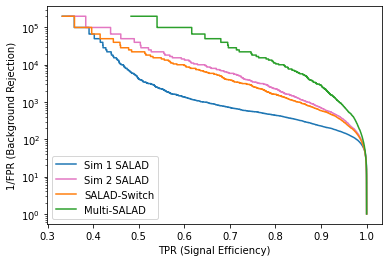

In [488]:
# plt.plot(tpr_12,1./fpr_12,color="tab:green",label="unweighted")

# plt.plot(tpr_1,1./fpr_1, "tab:blue",label="Sim 1 SALAD", linewidth= 1)
plt.plot(tpr_1_rw,1./fpr_1_rw,ls="-",color="tab:blue", label="Sim 1 SALAD")

#plt.plot(tpr_2,1./fpr_2,color="tab:pink",label="Sim 2 SALAD")
plt.plot(tpr_2_rw,1./fpr_2_rw,ls="-",color="tab:pink", label="Sim 2 SALAD")


plt.plot(tpr_multi_rw,1./fpr_multi_rw,ls="-",color="tab:orange", label="SALAD-Switch", linewidth= 1.5)
plt.plot(tpr_12_rw,1./fpr_12_rw,ls="-",color="tab:green", label="Multi-SALAD")



#plt.plot(tpr,1./tpr,color="gray",ls=":")
plt.yscale("log")
plt.xlabel("TPR (Signal Efficiency)")
plt.ylabel("1/FPR (Background Rejection)")
plt.legend()
plt.savefig("./figs/run3.pdf")
